In [1]:
import tensorflow as tf
import nltk
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

2024-03-24 19:57:57.646120: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 19:57:57.671562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 19:57:57.671584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 19:57:57.672232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 19:57:57.677273: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset,info=tfds.load('imdb_reviews',with_info=True,
                       as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

2024-03-24 19:58:09.961470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:58:09.979903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:58:09.979953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:58:09.982849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:58:09.982892: I external/local_xla/xla/stream_executor

In [3]:
train_dataset.element_spec
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2024-03-24 19:58:24.365788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Goodnight, Mister Tom begins in an impossibly exquisite village in the south of England where the sun always seems to shine. Before we have much idea of the period we hear a radio announcement of the declaration of World War II. Soon a train blowing clouds of steam brings refugee children from London and when shy little William is billeted with reluctant, gruff old Tom (who you just know will turn out to have a heart of gold) our tale begins.<br /><br />And what a load of sentimental claptrap it is. In fact it's just the old odd-couple buddy formula. Aren't any new stories being written?<br /><br />As I suggested there's hardly any period feel in the village and not much more in London apart from the odd old ambulance rattling around. And certainly no hint of the horror of the Blitz as London's citizens file politely into air-raid shelters. Even when the local schoolteacher's husband is declared missing presumed killed, he is later restored to life.<br /><br />I found `Goodn

2024-03-24 19:58:37.492137: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
vocab_size=1000
encoder=tf.keras.layers.TextVectorization(max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label:text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

encoded_example = encoder(example)[:3].numpy()
encoded_example

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

2024-03-24 19:58:50.559452: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Original:  b"Goodnight, Mister Tom begins in an impossibly exquisite village in the south of England where the sun always seems to shine. Before we have much idea of the period we hear a radio announcement of the declaration of World War II. Soon a train blowing clouds of steam brings refugee children from London and when shy little William is billeted with reluctant, gruff old Tom (who you just know will turn out to have a heart of gold) our tale begins.<br /><br />And what a load of sentimental claptrap it is. In fact it's just the old odd-couple buddy formula. Aren't any new stories being written?<br /><br />As I suggested there's hardly any period feel in the village and not much more in London apart from the odd old ambulance rattling around. And certainly no hint of the horror of the Blitz as London's citizens file politely into air-raid shelters. Even when the local schoolteacher's husband is declared missing presumed killed, he is later restored to life.<br /><br />I found `Goo

In [7]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1)#Solo hay 2 clases
])

In [8]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [9]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


1/1 [==============================] - 2s 2s/step
[-0.01058695]


2024-03-24 20:00:08.698488: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


In [12]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


1/1 [==============================] - 1s 1s/step
[-0.01058867]


In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10


2024-03-24 20:01:41.020822: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2024-03-24 20:01:41.769036: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f49684d6830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 20:01:41.769071: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Co

391/391 [==============================] - 73s 173ms/step - loss: 0.6418 - accuracy: 0.5690 - val_loss: 0.5341 - val_accuracy: 0.6323
Epoch 2/10


2024-03-24 20:02:49.907360: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 63s 161ms/step - loss: 0.4412 - accuracy: 0.7901 - val_loss: 0.3937 - val_accuracy: 0.8286
Epoch 3/10


2024-03-24 20:03:52.782228: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 56s 142ms/step - loss: 0.3587 - accuracy: 0.8442 - val_loss: 0.3513 - val_accuracy: 0.8458
Epoch 4/10


2024-03-24 20:04:48.335278: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 52s 134ms/step - loss: 0.3284 - accuracy: 0.8609 - val_loss: 0.3409 - val_accuracy: 0.8594
Epoch 5/10


2024-03-24 20:05:40.712433: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 54s 137ms/step - loss: 0.3181 - accuracy: 0.8642 - val_loss: 0.3318 - val_accuracy: 0.8552
Epoch 6/10


2024-03-24 20:06:34.267535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 53s 136ms/step - loss: 0.3100 - accuracy: 0.8684 - val_loss: 0.3310 - val_accuracy: 0.8536
Epoch 7/10


2024-03-24 20:07:27.519255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 52s 132ms/step - loss: 0.3058 - accuracy: 0.8711 - val_loss: 0.3253 - val_accuracy: 0.8547
Epoch 8/10


2024-03-24 20:08:19.289006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 52s 133ms/step - loss: 0.3032 - accuracy: 0.8703 - val_loss: 0.3343 - val_accuracy: 0.8469
Epoch 9/10


2024-03-24 20:09:11.619263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 52s 134ms/step - loss: 0.3022 - accuracy: 0.8716 - val_loss: 0.3252 - val_accuracy: 0.8526
Epoch 10/10


2024-03-24 20:10:03.953870: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 52s 133ms/step - loss: 0.2986 - accuracy: 0.8746 - val_loss: 0.3231 - val_accuracy: 0.8552


2024-03-24 20:10:55.986024: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 25s 64ms/step - loss: 0.3175 - accuracy: 0.8559
Test Loss: 0.3175062835216522
Test Accuracy: 0.8559200167655945


(0.0, 0.658943809568882)

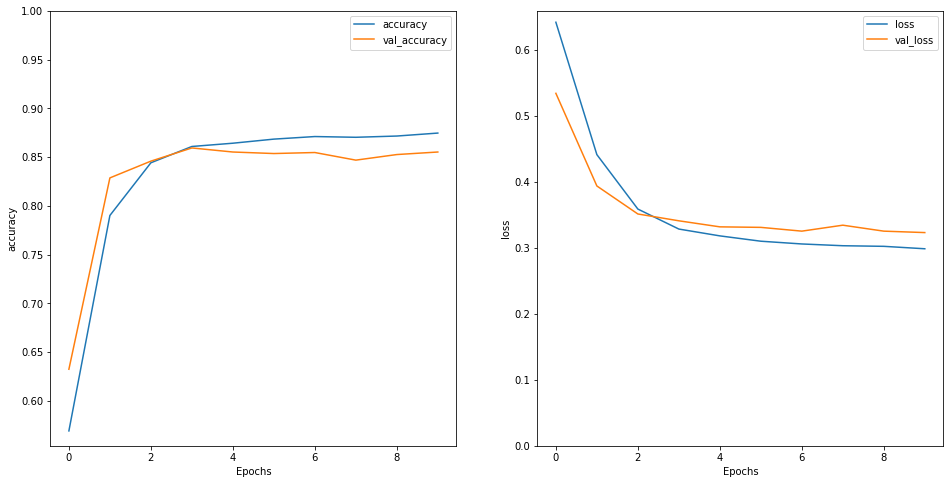

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [21]:
sample_text = ('The movie was quite slow, i would reccomend it but i dont know who may like it')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 19ms/step
[-0.24679556]


In [25]:
tf.saved_model.save(model, '/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P1/LSTM')

INFO:tensorflow:Assets written to: /mnt/d/Repositorios/Deep_Learning/Temas Selectos/P1/LSTM/assets


INFO:tensorflow:Assets written to: /mnt/d/Repositorios/Deep_Learning/Temas Selectos/P1/LSTM/assets
